## Pattern Separation Results

In [1]:
# import necessary libraries:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
OUTDATED_IGNORE=1
from pingouin import ttest
import pingouin as pg
import statsmodels.formula.api as sm2

C:\Users\tuq67942\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# add figure path
figurepath = 'C:/Users/tuq67942/OneDrive - Temple University/Documents/Figures/'
# import dfs
PSagedf = pd.read_csv('csvs/PSoutputdf_exactage_1.csv')
PSdf = pd.read_csv('csvs/PSoutputdf_1.csv')
stackeddf = pd.read_csv('csvs/PS_cat_Year_1.csv')
anovadf = pd.read_csv('csvs/PS_cat_anova_Year_1.csv')
# import dfs intern
#PSagedf = pd.read_csv('csvs/PSintern_1.csv')
#PSdf = pd.read_csv('csvs/PSintern_1.csv')
#stackeddf = pd.read_csv('csvs/PS_cat_intern_1.csv')
#anovadf = pd.read_csv('csvs/PS_cat_anova_intern_1.csv')

### Removing 9 immediate-group participants who did o.g. version of the task broken up into two blocks on two separate days:

In [3]:
def exclude_fun(df,exlist):
    df = df[~df.Subject.isin(exlist)]
    return df

exclude = 1
if exclude == 1:
    excludedf = stackeddf[stackeddf['Same Day'] == False]
    exclude_subjs = excludedf['Subject']
    PSagedf = exclude_fun(PSagedf,exclude_subjs)
    PSdf = exclude_fun(PSdf,exclude_subjs)
    stackeddf = exclude_fun(stackeddf,exclude_subjs)
    anovadf = exclude_fun(anovadf,exclude_subjs)

# Age, and Sex breakdown of participants - and of those who did/did not experience the delay:

In [4]:
d = {'Among all participants:':stackeddf,
    'Among participants who experienced a delay between encoding and retrieval:':
     stackeddf[stackeddf['Delay']==True],
    'Among participants who did not experienced a delay between encoding and retrieval:':
     stackeddf[stackeddf['Delay']==False]}

for k,df in d.items():
    print(k)
    print('N = '+str(len(df)))
    print('Ages ranged from: '+str(np.min(df['Age']))+' - '+\
          str(np.max(df['Age']))+' years, Mean = '+\
          str(np.round(np.mean(df['Age']),2))+\
          ' +/- '+str(np.round(np.std(df['Age']),2)))
    print(df['Sex'].value_counts())


Among all participants:
N = 83
Ages ranged from: 4.0 - 7.9 years, Mean = 5.77 +/- 1.21
Girl    52
Boy     31
Name: Sex, dtype: int64
Among participants who experienced a delay between encoding and retrieval:
N = 50
Ages ranged from: 4.07 - 7.88 years, Mean = 5.63 +/- 1.19
Girl    33
Boy     17
Name: Sex, dtype: int64
Among participants who did not experienced a delay between encoding and retrieval:
N = 33
Ages ranged from: 4.0 - 7.9 years, Mean = 5.97 +/- 1.21
Girl    19
Boy     14
Name: Sex, dtype: int64


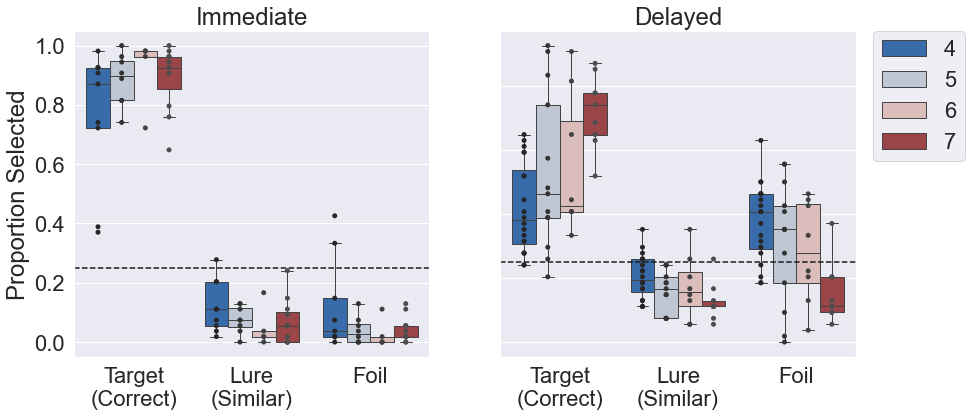

In [5]:
order = ['Target\n(Correct)','Lure\n(Similar)','Foil']
delaylabs = ['Immediate','Delayed']
orderage = [4,5,6,7]

sns.set(font_scale=2)
fig, ax = plt.subplots(1,2,figsize=(14, 6))
for i,delay in enumerate([False,True]):
    tmp = PSdf[PSdf['Delay']==delay]
    tmp = tmp.copy()
    tmp['Selection'] = tmp['Selection'].map({'Target': 'Target\n(Correct)', 'Lure': 'Lure\n(Similar)', 'Foil':'Foil'})
    sns.boxplot(data=tmp, x="Selection", y="Proportion Selected", hue="Age", palette="vlag",order=order, showfliers = False, ax = ax[i], legend=delay)
    sns.stripplot(data=tmp, x="Selection", y="Proportion Selected", hue="Age", dodge=True,palette='dark:.3',order=order, jitter=False,legend=False, ax = ax[i])
    ax[i].set(xlabel=None)
    ax[i].axhline(y=0.25, color='k', linestyle='--')
    ax[i].set_title(delaylabs[i])
ax[i].set(yticklabels=[])
ax[i].set(ylabel=None)

handles, labels = ax[i].get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


### Participants with 1 week delay are <i>clearly</i> off cieling, but is it significant?
### <b>Yes!</b>: Delay makes a significant difference in accuracy!

In [6]:
for sel in ['Target','Lure','Foil']:
    print(sel)
    display(ttest(
        stackeddf[stackeddf['Delay']==True][sel],
        stackeddf[stackeddf['Delay']==False][sel]))


Target


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-8.40595,79.497572,two-sided,1.348737e-12,"[-0.42, -0.26]",1.780404,4.783e+09,1.0


Lure


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.452428,69.34197,two-sided,7.174129e-07,"[0.06, 0.13]",1.219253,2.471e+04,0.999676


Foil


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,8.744811,79.906514,two-sided,2.812643e-13,"[0.19, 0.3]",1.76917,2.082e+10,1.0


In [7]:
ttest(stackeddf[(stackeddf['Sex']=='Girl')&(stackeddf['Delay']==True)]['Target'],
      stackeddf[(stackeddf['Sex']=='Boy')&(stackeddf['Delay']==True)]['Target'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.047354,30.694367,two-sided,0.049265,"[0.0, 0.25]",0.623737,1.552,0.534863


## Question from Nora/Zoe December 2023:
### Is this difference significant in all age groups (4, 5, 6, 7 y.o.'s)?

In [8]:
ages = [4,5,6,7,8]
for i in range(len(ages)-1):
    tmpdf = stackeddf[stackeddf['Age'].between(ages[i], ages[i+1])]
    print('age = '+str(ages[i]))
    display(ttest(tmpdf[tmpdf['Delay']==True]['Target'],tmpdf[tmpdf['Delay']==False]['Target']))

age = 4


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.098475,10.741588,two-sided,0.001853,"[-0.53, -0.16]",1.979755,71.707,0.997369


age = 5


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.725901,16.254946,two-sided,0.000219,"[-0.52, -0.2]",1.747366,141.269,0.957783


age = 6


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.133199,10.859619,two-sided,0.001709,"[-0.58, -0.18]",2.046283,18.995,0.903622


age = 7


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.385898,17.033239,two-sided,0.003505,"[-0.28, -0.06]",1.526027,11.842,0.894221


In [25]:
result = sm2.ols(formula='Target~Delay+Age+Age*Delay',data=stackeddf).fit()
print(result.summary()) #no interaction!

                            OLS Regression Results                            
Dep. Variable:                 Target   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     46.73
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           3.69e-18
Time:                        15:07:35   Log-Likelihood:                 40.746
No. Observations:                  92   AIC:                            -73.49
Df Residuals:                      88   BIC:                            -63.41
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.6125      0.12

### Are all age groups in the both conditions different from chance?

In [45]:
i=0
plist = []
#for d in [True,False]:
for sel in ['Target','Lure','Foil']:
    chance=0.5 if sel == 'Foil' else 0.25
    for age in [4,5,6,7]:
        tmpdf = stackeddf[stackeddf['Age'].between(age, age+1)]
        display(ttest(tmpdf[sel],chance))
        p = ttest(tmpdf[sel],chance)['p-val'][0]
        print(str(age)+" year olds' "+sel+" selection rate "+
              str(np.round(np.mean(tmpdf[sel]),2))+
             "+/-"+
             str(np.round(np.std(tmpdf[sel]),2)))
        i+=1
        plist.append({'Delay':d,'Selection':sel,'Age':age,
                     'p-value':p})
print(i)
dftmp = pd.DataFrame(plist)
#dftmp['p-value'] = dftmp['p-value'].apply(lambda x: x*i)
dftmp['sig'] = dftmp['p-value'].apply(lambda x: x>0.05)
dftmp['p-value'] = dftmp['p-value'].apply(lambda x: '%.3f' % x)
#display(dftmp[dftmp['sig']==True])
display(dftmp)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,6.306246,28,two-sided,8.060106e-07,"[0.43, 0.61]",1.17104,2.16e+04,0.999981


4 year olds' Target selection rate 0.52+/-0.23


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,7.134303,20,two-sided,6.522923e-07,"[0.54, 0.79]",1.556832,2.654e+04,1.0


5 year olds' Target selection rate 0.66+/-0.26


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,6.093118,12,two-sided,0.000054,"[0.53, 0.85]",1.689927,494.64,0.999839


6 year olds' Target selection rate 0.69+/-0.25


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,18.214796,19,two-sided,1.730251e-13,"[0.75, 0.88]",4.072952,3.601e+10,1.0


7 year olds' Target selection rate 0.82+/-0.14


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.66786,28,two-sided,0.000069,"[0.15, 0.21]",0.8668,366.649,0.994499


4 year olds' Lure selection rate 0.18+/-0.08


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-7.959093,20,two-sided,1.261623e-07,"[0.09, 0.16]",1.736817,1.205e+05,1.0


5 year olds' Lure selection rate 0.13+/-0.07


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.279476,12,two-sided,0.00107,"[0.06, 0.19]",1.186913,37.402,0.974844


6 year olds' Lure selection rate 0.12+/-0.1


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-9.441378,19,two-sided,1.317651e-08,"[0.06, 0.13]",2.111156,9.701e+05,1.0


7 year olds' Lure selection rate 0.09+/-0.07


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-6.100415,28,two-sided,0.000001,"[0.23, 0.37]",1.132819,1.298e+04,0.999956


4 year olds' Foil selection rate 0.3+/-0.18


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-6.600924,20,two-sided,0.000002,"[0.12, 0.3]",1.44044,9588.788,0.999991


5 year olds' Foil selection rate 0.21+/-0.2


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-6.348041,12,two-sided,0.000037,"[0.08, 0.29]",1.76063,692.401,0.999935


6 year olds' Foil selection rate 0.18+/-0.17


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-20.423165,19,two-sided,2.175829e-14,"[0.05, 0.13]",4.566758,2.54e+11,1.0


7 year olds' Foil selection rate 0.09+/-0.09
12


,Delay,Selection,Age,p-value,sig
0,False,Target,4,0.000,False
1,False,Target,5,0.000,False
2,False,Target,6,0.000,False
3,False,Target,7,0.000,False
4,False,Lure,4,0.000,False
5,False,Lure,5,0.000,False
6,False,Lure,6,0.001,False
7,False,Lure,7,0.000,False
8,False,Foil,4,0.000,False
9,False,Foil,5,0.000,False


# Let's just looks at those kids who had the delay going forward...

In [16]:
PSagedftmp1 = PSagedf[PSagedf['Delay']==True]
stackeddftmp1 = stackeddf[stackeddf['Delay']==True]

### plot correlation between age and Target/Lure/Foil proportion 

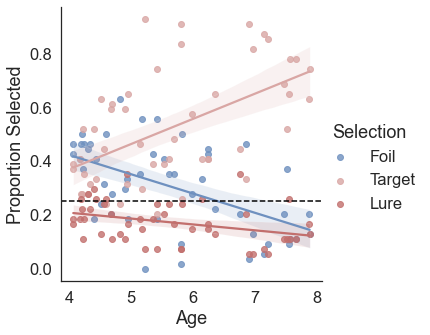

In [17]:
sns.set_theme(style="white",font_scale=1.5, palette=['#6e90bf',  '#d9a6a4', '#c26f6d'])
g = sns.lmplot(data=PSagedftmp1,x="Age", y="Proportion Selected", hue="Selection")
plt.axhline(y=0.25, color='k', linestyle='--')
g.savefig(figurepath+'PS_corr_Target_Lure_Foil.png', bbox_inches='tight', dpi=100)

### Correlation between age and proportion selected of Foil, Target, and Lure:

In [18]:
PSkey = {-1:'Foil',1:'Target',0:'Lure'}
statlist = []
for selection in PSkey.values():
	tmpdf = PSagedftmp1[PSagedftmp1['Selection'] == selection]
	res = stats.pearsonr(tmpdf['Age'],tmpdf['Proportion Selected'])
	statlist.append({'Selection':selection, 'Age/Prop r':res[0], 'Age/Prop p':res[1]})
statdf=pd.DataFrame(statlist)
display(statdf)

,Selection,Age/Prop r,Age/Prop p
0,Foil,-0.532835,0.000068
1,Target,0.539908,0.000052
2,Lure,-0.346888,0.013587


In [26]:
result = sm2.ols(formula='Age~Foil+Target+Lure+Foil*Lure',data=stackeddftmp1).fit()
print(result.summary()) #no interaction!

                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     6.789
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           0.000694
Time:                        15:07:41   Log-Likelihood:                -70.428
No. Observations:                  50   AIC:                             148.9
Df Residuals:                      46   BIC:                             156.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8809      1.172      4.166      0.0

### Is the relationship between Lures and age significantly different from the relationship between foils and age? <b>No!</b>
### <i>Code from chatGPT4!!</i>

In [20]:
import numpy as np
from scipy.stats import t

def fisher_z_transform(r):
    return 0.5 * np.log((1 + r) / (1 - r))

def williams_test(r1, r2, r12, n):
    """
    Williams' Test for dependent correlations.
    
    Parameters:
    r1: First correlation coefficient.
    r2: Second correlation coefficient.
    r12: Correlation coefficient between the two variables of interest.
    n: Sample size.
    
    Returns:
    t_value: Test statistic.
    p_value: Two-tailed p-value.
    """
    
    z1 = fisher_z_transform(r1)
    z2 = fisher_z_transform(r2)
    
    numerator = z1 - z2
    denominator = np.sqrt((1 / (n - 3)) * (2 * (1 - r1) / (1 + r1) + 2 * (1 - r2) / (1 + r2) - 2 * (1 - r12)))
    
    t_value = numerator / denominator
    df = n - 3  # Degrees of freedom
    p_value = (1 - t.cdf(abs(t_value), df)) * 2  # Two-tailed p-value
    
    return t_value, p_value

for pair in [['Foil','Lure'],['Target','Lure'],['Target','Foil']]:
    t_value, p_value = williams_test(statdf[statdf.Selection==pair[0]]['Age/Prop r'].iloc[0], 
                  statdf[statdf.Selection==pair[1]]['Age/Prop r'].iloc[0], 
                  stats.pearsonr(stackeddftmp1[pair[0]],stackeddftmp1[pair[1]])[0], 
                 len(stackeddftmp1))

    print("Interaction between "+pair[0]+"-selection and "+pair[1]+"-selection:")
    print(f"t-value: {t_value:.4f}")
    print(f"p-value: {p_value:.4f}")

Interaction between Foil-selection and Lure-selection:
t-value: -0.5131
p-value: 0.6103
Interaction between Target-selection and Lure-selection:
t-value: 5.8841
p-value: 0.0000
Interaction between Target-selection and Foil-selection:
t-value: 4.5451
p-value: 0.0000


### Investigating potential differences between the selection of correct objects, locations, and animals by age:

,Selection,Age/Prop r,Age/Prop p
0,object,0.500214,0.000216
1,location,0.405393,0.003494
2,animal,0.576781,0.000012


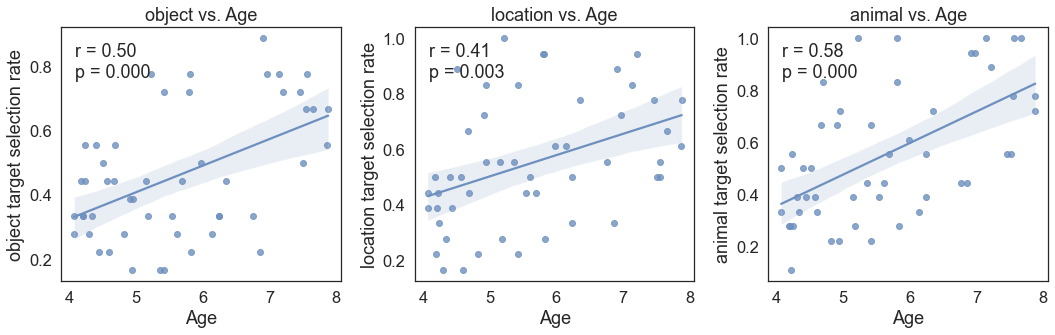

Target


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,Item,2,98,11.146079,0.000043,0.035232,0.930155


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Item,animal,location,True,True,0.090003,49.0,two-sided,0.928652,1.000000,bonf,0.154,0.009192
1,Item,animal,object,True,True,4.765979,49.0,two-sided,0.000017,0.000052,bonf,1160.227,0.402869
2,Item,location,object,True,True,4.000404,49.0,two-sided,0.000213,0.000640,bonf,114.961,0.418477


Lure


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,Item,2,98,2.655905,0.075289,0.026367,0.992279


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Item,animal,location,True,True,0.805446,49.0,two-sided,0.424454,1.000000,bonf,0.209,0.144361
1,Item,animal,object,True,True,-1.483534,49.0,two-sided,0.144337,0.433010,bonf,0.429,-0.234479
2,Item,location,object,True,True,-2.310337,49.0,two-sided,0.025122,0.075365,bonf,1.721,-0.415028


Foil


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,Item,2,98,6.135159,0.003087,0.023607,0.915505


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Item,animal,location,True,True,-0.807366,49.0,two-sided,0.423358,1.000000,bonf,0.209,-0.095527
1,Item,animal,object,True,True,-3.532496,49.0,two-sided,0.000908,0.002725,bonf,31.043,-0.367784
2,Item,location,object,True,True,-2.782627,49.0,two-sided,0.007636,0.022909,bonf,4.741,-0.266590


In [22]:
statlistola = []
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i,selection in enumerate(['object','location','animal']):
	res = stats.pearsonr(stackeddftmp1['Age'],stackeddftmp1[selection+' target selection rate'])
	statlistola.append({'Selection':selection, 'Age/Prop r':res[0], 'Age/Prop p':res[1]})
	sns.regplot(data=stackeddftmp1, x='Age', y=selection+' target selection rate', ax=axes[i]).set_title(selection+' vs. Age')
	axes[i].text(0.05, 0.8, f'r = {res[0]:.2f}\np = {res[1]:.3f}', transform=axes[i].transAxes)
statdfola=pd.DataFrame(statlistola)
display(statdfola)

plt.tight_layout()
plt.show()
 
tmp = anovadf[anovadf['Delay']==True]
for sel in ['Target','Lure','Foil']:
    print(sel)
    res = pg.rm_anova(dv=sel,within='Item',subject='Subject',
                  data=tmp)
    post_hocs = pg.pairwise_tests(dv=sel,within='Item',
                              subject='Subject',padjust='bonf',
                              data=tmp)
    display(res)
    display(post_hocs) 

### Are any of these correlation value significantly different from one another? <b>No!</b>

In [17]:
pairs = [['object','location'],['object','animal'],['animal','location']]
for pair in pairs:
    t_value, p_value = williams_test(statdfola[statdfola.Selection==pair[0]]['Age/Prop r'].iloc[0], 
                  statdfola[statdfola.Selection==pair[1]]['Age/Prop r'].iloc[0], 
                  stats.pearsonr(stackeddftmp1[pair[0]+' target selection rate'],
                                 stackeddftmp1[pair[1]+' target selection rate'])[0], 
                 len(stackeddftmp1))
    print(pair)
    print(f"t-value: {t_value:.4f}")
    print(f"p-value: {p_value:.4f}")

['object', 'location']
t-value: 0.8321
p-value: 0.4095
['object', 'animal']
t-value: -0.7866
p-value: 0.4355
['animal', 'location']
t-value: 1.6805
p-value: 0.0995


### Correlation between selection of object, location, and animal:

['object', 'location']
                            OLS Regression Results                            
Dep. Variable:               location   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     26.81
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           1.71e-08
Time:                        15:11:58   Log-Likelihood:                 22.739
No. Observations:                  50   AIC:                            -39.48
Df Residuals:                      47   BIC:                            -33.74
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1241      0.

,Item 1,Item 2,r,Age/Prop p
0,object,location,0.728438,2.022240e-09
1,location,animal,0.739317,8.691261e-10
2,object,animal,0.841720,1.914264e-14


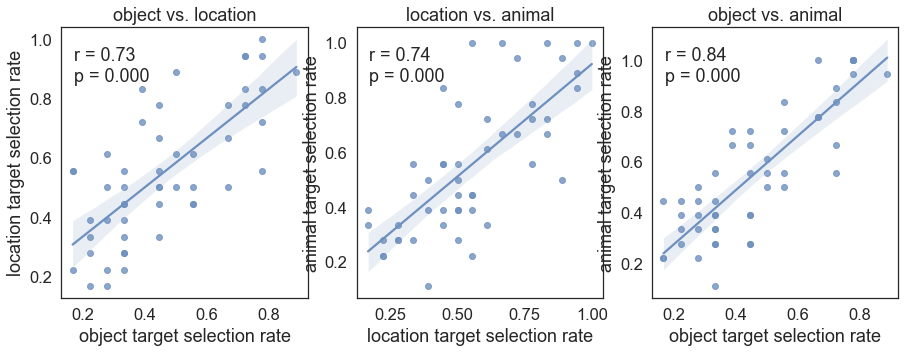

In [32]:
tmp = stackeddftmp1.rename(columns={'object target selection rate': 'object',
                                    'location target selection rate': 'location',
                                   'animal target selection rate':'animal'})
statlistola = []
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i,pair in enumerate([['object','location'],['location','animal'],['object','animal']]):
	res = stats.pearsonr(stackeddftmp1[pair[0]+' target selection rate'],
                         stackeddftmp1[pair[1]+' target selection rate'])
	statlistola.append({'Item 1':pair[0], 'Item 2':pair[1], 
                        'r':res[0], 'Age/Prop p':res[1]})
	sns.regplot(data=stackeddftmp1, x=pair[0]+' target selection rate',
                y=pair[1]+' target selection rate', ax=axes[i]).set_title(pair[0]+' vs. '+pair[1])
	axes[i].text(0.05, 0.8, f'r = {res[0]:.2f}\np = {res[1]:.3f}', transform=axes[i].transAxes)
	print(pair)
	result = sm2.ols(formula=pair[1]+'~'+pair[0]+'+Age',data=tmp).fit()
	print(result.summary())
    
statdfola=pd.DataFrame(statlistola)
display(statdfola)




### Does length of delay effect accuracy?

In [52]:
delaydf = pd.read_csv('csvs/Delay_Days_1.csv')
PSkey = {-1:'Foil',1:'Target',0:'Lure'}
statlist = []
for selection in PSkey.values():
	tmpdf = PSagedftmp1[PSagedftmp1['Selection'] == selection]
	tmpdf = tmpdf.merge(delaydf, on=['Subject'],how='left', indicator=True)
	res = stats.pearsonr(tmpdf['Delay Days'],tmpdf['Proportion Selected'])
	statlist.append({'Selection':selection, 'Age/Prop r':res[0], 'Age/Prop p':res[1]})
statdf=pd.DataFrame(statlist)
display(statdf)


,Selection,Age/Prop r,Age/Prop p
0,Foil,0.182443,0.204759
1,Target,-0.262134,0.065917
2,Lure,0.331137,0.018826


# Here: Analyzing only kids WITHOUT the delay

In [33]:
PSagedftmp0 = PSagedf[PSagedf['Delay']==False]
stackeddftmp0 = stackeddf[stackeddf['Delay']==False]

## Is <i>immediate</i> group at ceiling?

In [34]:
display(ttest(stackeddftmp0['Target'],1))

for age in [4,5,6,7]:
        print('Age = '+str(age))
        tmp = stackeddftmp0[stackeddftmp0['Age'].between(age, age+1)]
        display(ttest(tmp['Target'],1.0))
        print(str(age)+" year olds' accuracy is "+
              str(np.round(np.mean(tmp['Target']),2))+
             "+/-"+
             str(np.round(np.std(tmp['Target']),2)))

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.799126,41,two-sided,8.351743e-07,"[0.83, 0.92]",0.894825,1.998e+04,0.999892


Age = 4


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.155104,10,two-sided,0.010244,"[0.64, 0.94]",0.9513,5.936,0.811081


4 year olds' accuracy is 0.79+/-0.21
Age = 5


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.320066,8,two-sided,0.002546,"[0.82, 0.94]",1.440022,19.122,0.964193


5 year olds' accuracy is 0.88+/-0.08
Age = 6


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.803652,8,two-sided,0.023068,"[0.85, 0.99]",0.934551,3.298,0.690949


6 year olds' accuracy is 0.92+/-0.08
Age = 7


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.35012,12,two-sided,0.005779,"[0.84, 0.97]",0.929156,9.087,0.867072


7 year olds' accuracy is 0.9+/-0.1


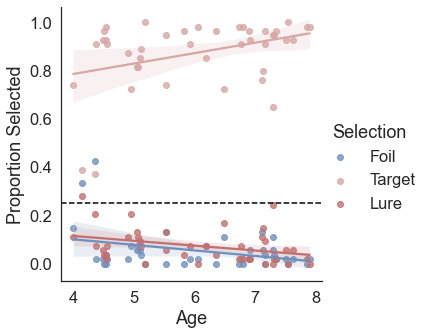

In [35]:
sns.set_theme(style="white",font_scale=1.5, palette=['#6e90bf',  '#d9a6a4', '#c26f6d'])
g = sns.lmplot(data=PSagedftmp0,x="Age", y="Proportion Selected", hue="Selection")
plt.axhline(y=0.25, color='k', linestyle='--')

In [36]:
PSkey = {-1:'Foil',1:'Target',0:'Lure'}
statlist = []
for selection in PSkey.values():
	tmpdf = PSagedftmp0[PSagedftmp0['Selection'] == selection]
	res = stats.pearsonr(tmpdf['Age'],tmpdf['Proportion Selected'])
	statlist.append({'Selection':selection, 'Age/Prop r':res[0], 'Age/Prop p':res[1]})
statdf=pd.DataFrame(statlist)
display(statdf)

,Selection,Age/Prop r,Age/Prop p
0,Foil,-0.331479,0.031998
1,Target,0.368510,0.016335
2,Lure,-0.355925,0.020702


In [37]:
result = sm2.ols(formula='Age~Foil+Target+Lure+Foil*Lure',data=stackeddftmp0).fit()
print(result.summary()) #no interaction!

                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     2.057
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.122
Time:                        15:12:43   Log-Likelihood:                -64.149
No. Observations:                  42   AIC:                             136.3
Df Residuals:                      38   BIC:                             143.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7125      1.950      1.904      0.0

In [38]:
for pair in [['Foil','Lure'],['Target','Lure'],['Target','Foil']]:
    t_value, p_value = williams_test(statdf[statdf.Selection==pair[0]]['Age/Prop r'].iloc[0], 
                  statdf[statdf.Selection==pair[1]]['Age/Prop r'].iloc[0], 
                  stats.pearsonr(stackeddftmp0[pair[0]],stackeddftmp0[pair[1]])[0], 
                 len(stackeddftmp0))

    print("Interaction between "+pair[0]+"-selection and "+pair[1]+"-selection:")
    print(f"t-value: {t_value:.4f}")
    print(f"p-value: {p_value:.4f}")

Interaction between Foil-selection and Lure-selection:
t-value: 0.0626
p-value: 0.9504
Interaction between Target-selection and Lure-selection:
t-value: 4.1433
p-value: 0.0002
Interaction between Target-selection and Foil-selection:
t-value: 4.5206
p-value: 0.0001


,Selection,Age/Prop r,Age/Prop p
0,object,0.173159,0.272797
1,location,0.458024,0.002287
2,animal,0.343800,0.025795


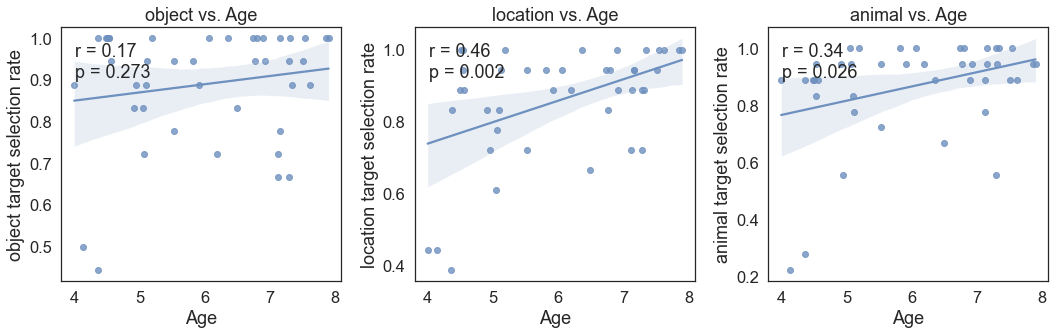

Target


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,Item,2,82,1.409014,0.250238,0.006697,0.956083


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Item,animal,location,True,True,0.393341,41.0,two-sided,0.696106,1.000000,bonf,0.179,0.046791
1,Item,animal,object,True,True,-1.164288,41.0,two-sided,0.251038,0.753113,bonf,0.313,-0.140002
2,Item,location,object,True,True,-1.817064,41.0,two-sided,0.076522,0.229565,bonf,0.748,-0.202720


Lure


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,Item,2,82,0.041709,0.959169,0.000373,0.895804


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Item,animal,location,True,True,-0.255309,41.0,two-sided,0.799761,1.0,bonf,0.172,-0.044629
1,Item,animal,object,True,True,-0.180459,41.0,two-sided,0.857681,1.0,bonf,0.169,-0.029490
2,Item,location,object,True,True,0.115658,41.0,two-sided,0.908488,1.0,bonf,0.168,0.015968


Foil


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,Item,2,82,3.286465,0.042367,0.018032,0.963747


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Item,animal,location,True,True,-0.295249,41.0,two-sided,0.769293,1.000000,bonf,0.174,-0.037540
1,Item,animal,object,True,True,2.176309,41.0,two-sided,0.035347,0.106042,bonf,1.39,0.262405
2,Item,location,object,True,True,2.453697,41.0,two-sided,0.018478,0.055433,bonf,2.38,0.326282


In [39]:
statlistola = []
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i,selection in enumerate(['object','location','animal']):
	res = stats.pearsonr(stackeddftmp0['Age'],stackeddftmp0[selection+' target selection rate'])
	statlistola.append({'Selection':selection, 'Age/Prop r':res[0], 'Age/Prop p':res[1]})
	sns.regplot(data=stackeddftmp0, x='Age', y=selection+' target selection rate', ax=axes[i]).set_title(selection+' vs. Age')
	axes[i].text(0.05, 0.8, f'r = {res[0]:.2f}\np = {res[1]:.3f}', transform=axes[i].transAxes)
statdfola=pd.DataFrame(statlistola)
display(statdfola)

plt.tight_layout()
plt.show()

tmp = anovadf[anovadf['Delay']==False]
for sel in ['Target','Lure','Foil']:
    print(sel)
    res = pg.rm_anova(dv=sel,within='Item',subject='Subject',
                  data=tmp)
    post_hocs = pg.pairwise_tests(dv=sel,within='Item',
                              subject='Subject',padjust='bonf',
                              data=tmp)
    display(res)
    display(post_hocs)

In [40]:
pairs = [['object','location'],['object','animal'],['animal','location']]
for pair in pairs:
    t_value, p_value = williams_test(statdfola[statdfola.Selection==pair[0]]['Age/Prop r'].iloc[0], 
                  statdfola[statdfola.Selection==pair[1]]['Age/Prop r'].iloc[0], 
                  stats.pearsonr(stackeddftmp0[pair[0]+' target selection rate'],
                                 stackeddftmp0[pair[1]+' target selection rate'])[0], 
                 len(stackeddftmp0))
    print(pair)
    print(f"t-value: {t_value:.4f}")
    print(f"p-value: {p_value:.4f}")

['object', 'location']
t-value: -1.5630
p-value: 0.1261
['object', 'animal']
t-value: -0.8517
p-value: 0.3996
['animal', 'location']
t-value: -0.8036
p-value: 0.4265


### Correlation between selection of object, location, and animal:

['object', 'location']
                            OLS Regression Results                            
Dep. Variable:               location   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     37.87
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           7.27e-10
Time:                        15:14:08   Log-Likelihood:                 41.014
No. Observations:                  42   AIC:                            -76.03
Df Residuals:                      39   BIC:                            -70.82
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0994      0.

,Item 1,Item 2,r,Age/Prop p
0,object,location,0.740227,2.111793e-08
1,location,animal,0.701860,2.232223e-07
2,object,animal,0.711889,1.250086e-07


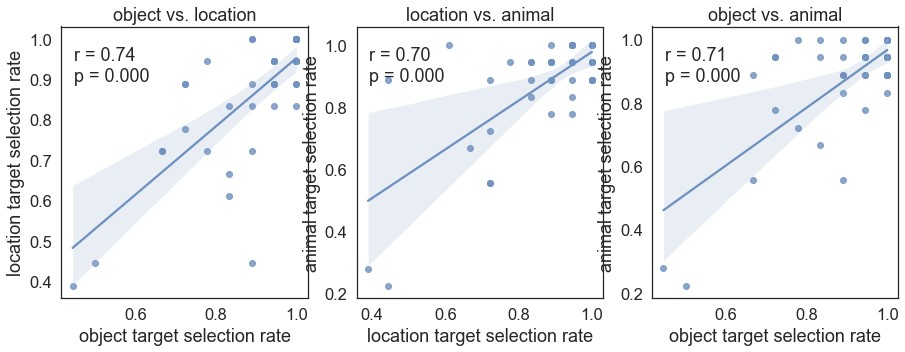

In [41]:
tmp = stackeddftmp0.rename(columns={'object target selection rate': 'object',
                                    'location target selection rate': 'location',
                                   'animal target selection rate':'animal'})
statlistola = []
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i,pair in enumerate([['object','location'],['location','animal'],['object','animal']]):
	res = stats.pearsonr(stackeddftmp0[pair[0]+' target selection rate'],
                         stackeddftmp0[pair[1]+' target selection rate'])
	statlistola.append({'Item 1':pair[0], 'Item 2':pair[1], 
                        'r':res[0], 'Age/Prop p':res[1]})
	sns.regplot(data=stackeddftmp0, x=pair[0]+' target selection rate',
                y=pair[1]+' target selection rate', ax=axes[i]).set_title(pair[0]+' vs. '+pair[1])
	axes[i].text(0.05, 0.8, f'r = {res[0]:.2f}\np = {res[1]:.3f}', transform=axes[i].transAxes)
	print(pair)
	result = sm2.ols(formula=pair[1]+'~'+pair[0]+'+Age',data=tmp).fit()
	print(result.summary())
    
statdfola=pd.DataFrame(statlistola)
display(statdfola)




## Nora question: Did the immediate group "learn to learn" - in other words is there a performance difference between session 1 and session 2?

In [26]:
for sel in ['Target','Lure','Foil']:
    print(sel)
    display(ttest(stackeddftmp0[sel+' first'], stackeddftmp0[sel+' second'], paired=True))
    print('Mean '+sel+' rate in first half:')
    print(np.round(np.mean(stackeddftmp0[sel+' first']),2))
    print('+/-')
    print(np.round(np.std(stackeddftmp0[sel+' first']),2))
    print('Mean '+sel+' rate in second half:')
    print(np.round(np.mean(stackeddftmp0[sel+' second']),2))
    print('+/-')
    print(np.round(np.std(stackeddftmp0[sel+' second']),2))
    
print('There is no change in Target/Lure/Foil selection rate\n'+
'between first and second session')

Target


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.469545,32,two-sided,0.641864,"[-0.03, 0.04]",0.047927,0.206,0.058215


Mean Target rate in first half:
0.86
+/-
0.15
Mean Target rate in second half:
0.86
+/-
0.17
Lure


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.665129,32,two-sided,0.510734,"[-0.01, 0.03]",0.08408,0.229,0.07552


Mean Lure rate in first half:
0.08
+/-
0.09
Mean Lure rate in second half:
0.08
+/-
0.07
Foil


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.123291,32,two-sided,0.269671,"[-0.04, 0.01]",0.144606,0.332,0.127092


Mean Foil rate in first half:
0.05
+/-
0.08
Mean Foil rate in second half:
0.07
+/-
0.12
There is no change in Target/Lure/Foil selection rate
between first and second session


## New Results requested by Nora and Zoe (in December 2023):
### Is the relationship between age and target/lure/foil selection significantly different between delay and no-delay group?

### 1) Is there an interaction between age and delay and target/lure/foil selection?

In [27]:
for selection in PSkey.values():
    # Test for interaction:
    result = sm2.ols(formula=selection+' ~ Age + Delay + Age * Delay',
                     data=stackeddf).fit()    
    print(selection)
    print(result.summary()) 

Foil
                            OLS Regression Results                            
Dep. Variable:                   Foil   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     36.32
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           7.43e-15
Time:                        13:18:35   Log-Likelihood:                 59.478
No. Observations:                  83   AIC:                            -111.0
Df Residuals:                      79   BIC:                            -101.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2270     

### 2) 3 way interation: 'Proportion Selected' ~ Age + Delay + Selection (Foil or Lure) + Age X Delay X Selection (With Subject as grouping factor)

In [60]:
PSagedftmp = PSagedf.rename({'Proportion Selected':'PS'},axis=1)
PSagedftmp = PSagedftmp[~PSagedftmp.Selection.isin(["Target"])]
PSagedftmp.loc[PSagedftmp['Selection'] == 'Foil','PS'] = PSagedftmp.loc[PSagedftmp['Selection'] == 'Foil','PS']/2
model = sm2.mixedlm("PS ~ Delay + Age + Selection + Delay*Age*Selection", PSagedftmp, groups=PSagedftmp["Subject"]) # Random Intercept
result = model.fit()
print(result.summary())

PSagedftmp = PSagedf.rename({'Proportion Selected':'PS'},axis=1)
vals = PSagedftmp[PSagedftmp['Selection']!='Foil'].groupby('Subject')['PS'].sum()
PSlist = []
for subj in PSagedftmp['Subject'].unique():
    d = dict(PSagedftmp[PSagedftmp['Subject']==subj].iloc[0][0:5])
    PSlist.append(d | {'Selection':'Target+Lure',
                       'PS':vals[subj]})
    PSlist.append(d | {'Selection':'Foil',
                       'PS':PSagedftmp[(PSagedftmp['Selection']=='Foil')&
                                        (PSagedftmp['Subject']==subj)]['PS'].iloc[0]})
newPSdf = pd.DataFrame(PSlist)
model = sm2.mixedlm("PS ~ Delay + Age + Selection + Delay*Age*Selection", newPSdf, groups=newPSdf["Subject"]) # Random Intercept
result = model.fit()
print(result.summary())
    


C:\Users\tuq67942\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         PS      
No. Observations:         166             Method:                     REML    
No. Groups:               83              Scale:                      0.0025  
Min. group size:          2               Log-Likelihood:             197.4387
Max. group size:          2               Converged:                  Yes     
Mean group size:          2.0                                                 
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                            0.114    0.058  1.948 0.051 -0.001  0.228
Delay[T.True]                        0.241    0.074  3.264 0.001  0.096  0.386
Selection[T.Lure]                    0.088    0.062  1.434 0.152 -0.032  

C:\Users\tuq67942\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tuq67942\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\tuq67942\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tuq67942\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


                        Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           PS     
No. Observations:             166               Method:                       REML   
No. Groups:                   83                Scale:                        0.0147 
Min. group size:              2                 Log-Likelihood:               93.1395
Max. group size:              2                 Converged:                    No     
Mean group size:              2.0                                                    
-------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                   0.227    0.107  2.125 0.034  0.018  0.436
Delay[T.True]                               0.482    0.135  3.560 0.000  0.217

C:\Users\tuq67942\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tuq67942\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\tuq67942\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 14.067234
  warnings.warn(msg, ConvergenceWarning)
C:\Users\tuq67942\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\tuq67942\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessi

In [66]:
PSagedftmp = PSagedf.rename({'Proportion Selected':'PS'},axis=1)
PSagedftmp = PSagedftmp[~PSagedftmp.Selection.isin(["Target"])]
PSagedftmp = PSagedftmp[PSagedftmp["Delay"] == True]
PSagedftmp.loc[PSagedftmp['Selection'] == 'Foil','PS'] = PSagedftmp.loc[PSagedftmp['Selection'] == 'Foil','PS']/2
model = sm2.mixedlm("PS ~ Age + Selection + Age*Selection", PSagedftmp, groups=PSagedftmp["Subject"]) # Random Intercept
result = model.fit()
print(result.summary())

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    PS      
No. Observations:     100        Method:                REML    
No. Groups:           50         Scale:                 0.0032  
Min. group size:      2          Log-Likelihood:        113.6197
Max. group size:      2          Converged:             Yes     
Mean group size:      2.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.355    0.048  7.354 0.000  0.260  0.449
Selection[T.Lure]     -0.059    0.055 -1.077 0.281 -0.166  0.048
Age                   -0.036    0.008 -4.279 0.000 -0.052 -0.019
Age:Selection[T.Lure]  0.014    0.009  1.471 0.141 -0.005  0.033
Group Var              0.002    0.017                           



C:\Users\tuq67942\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [63]:
betas = []
stderrs = []
for sel in ['Target+Lure','Foil']:
    model = sm2.glm("PS ~ Delay + Age + Delay*Age", newPSdf[newPSdf['Selection']==sel]) # Random Intercept
    result = model.fit()
    print('Selection = '+sel)
    print(result.summary())
    betas.append(result.params["Delay[T.True]:Age"])
    stderrs.append(result.bse["Delay[T.True]:Age"])
z = (betas[0]-betas[1])/np.sqrt(np.square(stderrs[0])+np.square(stderrs[1]))
print(z)

Selection = Target+Lure
                 Generalized Linear Model Regression Results                  
Dep. Variable:                     PS   No. Observations:                   83
Model:                            GLM   Df Residuals:                       79
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                        0.014674
Method:                          IRLS   Log-Likelihood:                 59.478
Date:                Mon, 05 Aug 2024   Deviance:                       1.1592
Time:                        10:33:14   Pearson chi2:                     1.16
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7312
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept     

In [56]:
for sel in ['Foil','Lure']:
    for age in [4,5,6,7]:
        print(sel,age)
        tmp = PSagedf[PSagedf.Selection.isin([sel])]
        tmp = tmp[tmp['Age'].between(age, age+1)]
        display(ttest(tmp[tmp['Delay']==False]['Proportion Selected'],
                     tmp[tmp['Delay']==True]['Proportion Selected']))
        

Foil 4


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.431661,12.519407,two-sided,0.00074,"[-0.39, -0.13]",1.963902,150.136,0.997043


Foil 5


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.989229,14.17606,two-sided,0.000191,"[-0.39, -0.16]",1.791899,231.74,0.965554


Foil 6


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.275439,8.894637,two-sided,0.00212,"[-0.39, -0.12]",1.979122,22.788,0.884217


Foil 7


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.19911,10.642883,two-sided,0.00881,"[-0.19, -0.03]",1.54263,8.674,0.900445


Lure 4


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.482756,12.454284,two-sided,0.028172,"[-0.15, -0.01]",1.103195,3.114,0.754793


Lure 5


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.338292,18.612396,two-sided,0.00353,"[-0.13, -0.03]",1.37376,11.339,0.82629


Lure 6


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.643212,10.849751,two-sided,0.0231,"[-0.23, -0.02]",1.37126,2.96,0.59208


Lure 7


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.959471,17.942295,two-sided,0.065781,"[-0.12, 0.0]",0.856626,1.426,0.438144


### None of the correlation values (age x accuracy correlation) are significantly different between delay and no-delay

In [29]:
# Code from chat GPT:
from scipy.stats import norm

# Function to transform Pearson r to Fisher Z
def r_to_z(r):
    return np.arctanh(r)

# Function to calculate standard error for Fisher Z
def standard_error(n):
    return 1/np.sqrt(n-3)

# Function to test the difference in correlation coefficients
def test_correlation_difference(r1, n1, r2, n2):
    z1 = r_to_z(r1)
    z2 = r_to_z(r2)
    se1 = standard_error(n1)
    se2 = standard_error(n2)

    # Calculate z-score for the difference
    z_diff = (z1 - z2) / np.sqrt(se1**2 + se2**2)
    p_value = 2 * (1 - norm.cdf(abs(z_diff)))

    return z_diff, p_value

for selection in PSkey.values():
	tmpdf = PSagedf[PSagedf['Selection'] == selection]
	tmpdf1 = tmpdf[tmpdf['Delay'] == False]
	res1 = stats.pearsonr(tmpdf1['Age'],tmpdf1['Proportion Selected'])[0]
	tmpdf2 = tmpdf[tmpdf['Delay'] == True]
	res2 = stats.pearsonr(tmpdf2['Age'],tmpdf2['Proportion Selected'])[0]
	z_diff, p_value = test_correlation_difference(res1, len(tmpdf1), res2, len(tmpdf2))
	print('Difference in correlations for: '+selection)
	print(f"Z-difference: {z_diff}, P-value: {p_value}")
    
tmpdf1 = stackeddf[stackeddf['Delay'] == False]
tmpdf2 = stackeddf[stackeddf['Delay'] == True]
for selection in ['object','location','animal']:
    res1 = stats.pearsonr(tmpdf1['Age'],tmpdf1[selection+' target selection rate'])[0]
    res2 = stats.pearsonr(tmpdf2['Age'],tmpdf2[selection+' target selection rate'])[0]
    z_diff, p_value = test_correlation_difference(res1, len(tmpdf1), res2, len(tmpdf2))
    print('Difference in correlations for: '+selection)
    print(f"Z-difference: {z_diff}, P-value: {p_value}")

Difference in correlations for: Foil
Z-difference: 0.9016797752358398, P-value: 0.3672269996645068
Difference in correlations for: Target
Z-difference: -0.8858990564032884, P-value: 0.3756719246548408
Difference in correlations for: Lure
Z-difference: 0.06617215969857682, P-value: 0.9472407615223204
Difference in correlations for: object
Z-difference: -1.66732126774987, P-value: 0.09545053988716234
Difference in correlations for: location
Z-difference: 0.5104642729654563, P-value: 0.6097262382128381
Difference in correlations for: animal
Z-difference: -1.2898718425931905, P-value: 0.19709515860533977


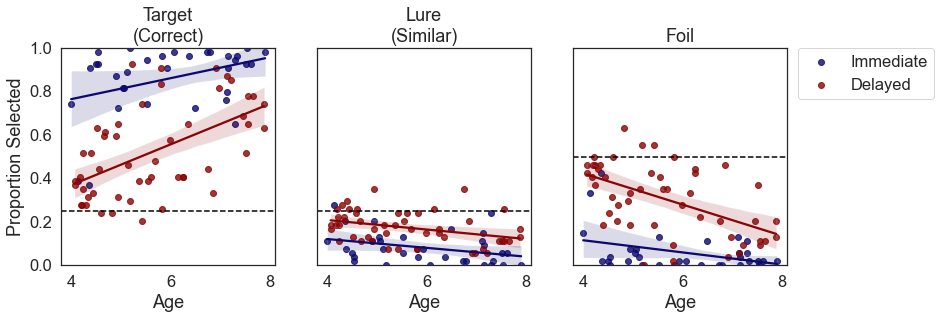

In [6]:
order = ['Target','Lure','Foil']
title = ['Target\n(Correct)', 'Lure\n(Similar)', 'Foil']
sns.set_theme(style="white",font_scale=1.5, palette=['#0D096E','#890505'])
fig,ax=plt.subplots(1,3,figsize=(13, 4))
for i,selection in enumerate(order):
    tmp = PSagedf[PSagedf['Selection']==selection]
    sns.regplot(data=tmp[tmp['Delay']==False],x="Age", y="Proportion Selected",ax=ax[i],label='Immediate')
    sns.regplot(data=tmp[tmp['Delay']==True],x="Age", y="Proportion Selected",ax=ax[i],label='Delayed')
    ax[i].set_ylim([0,1])
    line = 0.25 if i != 2 else 0.5
    ax[i].axhline(y=line, color='k', linestyle='--')
    ax[i].set_title(title[i])
    if i>0:
        ax[i].set(yticklabels=[])
        ax[i].set(ylabel=None)
handles, labels = ax[i].get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('Figures/Figure1.tif', dpi=300,bbox_inches="tight", format='tif')
plt.show()
